In [42]:
import numpy as  np
times = np.linspace(20,400,100)

In [43]:
a  = 2
c = 2
b = 3


delta_x = np.array([np.random.gamma(a*(times[i]**c- times[i-1]**c), b, 1) for i in range(1,len(times)) ])






In [54]:
from scipy.special import loggamma

def neg_log_likehood(params, delta_x, t):
    a, b, c = params[0], params[1], params[2]
    
    # Constraint: prevent invalid parameters
    if a <= 0 or b <= 0 or c <= 0:
        return 1e10
    
    # Flatten delta_x in case it's 2D
    dx = delta_x.flatten()
    
    try:
        # Time differences with numerical stability
        time_diff = t[1:len(t)]**c - t[0:len(t)-1]**c
        
        # Shape parameter for each observation
        shape = a * time_diff
        
        # Prevent negative or zero shape
        if np.any(shape <= 0):
            return 1e10
        
        # Prevent log of non-positive values
        if np.any(dx <= 0):
            return 1e10
        
        # Gamma log-likelihood: sum of log p(x | shape, scale)
        # log p(x) = (shape-1)*log(x) - x/scale - shape*log(scale) - loggamma(shape)
        ll = (shape - 1) * np.log(dx) - dx / b - shape * np.log(b) - loggamma(shape)
        
        # Check for NaN
        if np.any(np.isnan(ll)) or np.any(np.isinf(ll)):
            return 1e10
        
        return -np.sum(ll)
    except:
        return 1e10

# Test with true parameters
print("NLL at true params:", neg_log_likehood([a, b, c], delta_x, times))

NLL at true params: 641.5673704628784


In [55]:
from scipy.optimize import minimize

init_guess = [2, 3, 2]  # Start closer to true values

# Tighter bounds to avoid numerical issues
bounds = [(0.1, 20), (0.1, 20), (0.1, 5)]

# Optimize
result = minimize(
    neg_log_likehood,
    init_guess,
    args=(delta_x, times),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract results
a_hat, b_hat, c_hat = result.x
print("Estimated parameters (L-BFGS-B):")
print(f"a = {a_hat:.4f} (true: {a})")
print(f"b = {b_hat:.4f} (true: {b})")
print(f"c = {c_hat:.4f} (true: {c})")
print("Negative log-likelihood at optimum:", result.fun)
print("Success:", result.success)
print("Message:", result.message)

Estimated parameters (L-BFGS-B):
a = 1.9289 (true: 2)
b = 3.1309 (true: 3)
c = 1.9988 (true: 2)
Negative log-likelihood at optimum: 641.4280372992234
Success: True
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH


In [56]:
# Differential Evolution (Global Optimizer)
from scipy.optimize import differential_evolution

bounds_de = [(0.1, 20), (0.1, 20), (0.1, 5)]

result_de = differential_evolution(
    neg_log_likehood,
    bounds_de,
    args=(delta_x, times),
    seed=42,
    maxiter=1000,
    atol=1e-10,
    tol=1e-10
)

print("\n=== Differential Evolution ===")
print("Estimated parameters:")
print(f"a = {result_de.x[0]:.4f} (true: {a})")
print(f"b = {result_de.x[1]:.4f} (true: {b})")
print(f"c = {result_de.x[2]:.4f} (true: {c})")
print("Negative log-likelihood:", result_de.fun)
print("Success:", result_de.success)


=== Differential Evolution ===
Estimated parameters:
a = 1.9289 (true: 2)
b = 3.1308 (true: 3)
c = 1.9988 (true: 2)
Negative log-likelihood: 641.4280372471803
Success: True


In [57]:
# Nelder-Mead (Derivative-free)
result_nm = minimize(
    neg_log_likehood,
    init_guess,
    args=(delta_x, times),
    method='Nelder-Mead',
    options={'maxiter': 10000, 'xatol': 1e-10, 'fatol': 1e-10}
)

print("\n=== Nelder-Mead ===")
print("Estimated parameters:")
print(f"a = {result_nm.x[0]:.4f} (true: {a})")
print(f"b = {result_nm.x[1]:.4f} (true: {b})")
print(f"c = {result_nm.x[2]:.4f} (true: {c})")
print("Negative log-likelihood:", result_nm.fun)
print("Success:", result_nm.success)


=== Nelder-Mead ===
Estimated parameters:
a = 1.9289 (true: 2)
b = 3.1309 (true: 3)
c = 1.9988 (true: 2)
Negative log-likelihood: 641.4280372435342
Success: True


In [58]:
# Convergence Diagnostics - Compute Hessian and Standard Errors
from scipy.optimize import approx_fprime
from scipy.stats import t as t_dist

def hessian_fd(params, delta_x, times, eps=1e-5):
    """Compute numerical Hessian using finite differences"""
    n_params = len(params)
    hessian = np.zeros((n_params, n_params))
    
    for i in range(n_params):
        for j in range(n_params):
            params_pp = params.copy()
            params_pp[i] += eps
            params_pp[j] += eps
            f_pp = neg_log_likehood(params_pp, delta_x, times)
            
            params_pm = params.copy()
            params_pm[i] += eps
            params_pm[j] -= eps
            f_pm = neg_log_likehood(params_pm, delta_x, times)
            
            params_mp = params.copy()
            params_mp[i] -= eps
            params_mp[j] += eps
            f_mp = neg_log_likehood(params_mp, delta_x, times)
            
            params_mm = params.copy()
            params_mm[i] -= eps
            params_mm[j] -= eps
            f_mm = neg_log_likehood(params_mm, delta_x, times)
            
            hessian[i, j] = (f_pp - f_pm - f_mp + f_mm) / (4 * eps ** 2)
    
    return hessian

# Compute Hessian and inverse (covariance matrix)
hessian = hessian_fd(result.x, delta_x, times)
try:
    cov_matrix = np.linalg.inv(hessian)
    std_errors = np.sqrt(np.diag(cov_matrix))
    
    print("\n=== L-BFGS-B with Standard Errors ===")
    print(f"a = {result.x[0]:.4f} ± {std_errors[0]:.4f}")
    print(f"b = {result.x[1]:.4f} ± {std_errors[1]:.4f}")
    print(f"c = {result.x[2]:.4f} ± {std_errors[2]:.4f}")
except np.linalg.LinAlgError:
    print("Hessian is singular - optimization may not have converged properly")


=== L-BFGS-B with Standard Errors ===
a = 1.9289 ± 0.2771
b = 3.1309 ± 0.4447
c = 1.9988 ± 0.0038


In [ ]:
# Bootstrap Confidence Intervals
np.random.seed(42)
n_bootstrap = 100
bootstrap_params = np.zeros((n_bootstrap, 3))

# Use wider bounds for bootstrap
bounds_boot = [(0.01, 50), (0.01, 50), (0.01, 10)]

print("\n=== Bootstrap Resampling (100 iterations) ===")
for i in range(n_bootstrap):
    # Resample with replacement
    idx = np.random.choice(len(delta_x), len(delta_x), replace=True)
    delta_x_boot = delta_x[idx]
    
    # Optimize on bootstrap sample
    result_boot = minimize(
        neg_log_likehood,
        result.x,  # Use previous result as starting point
        args=(delta_x_boot, times),
        bounds=bounds_boot,
        method='L-BFGS-B',
        options={'ftol': 1e-10}
    )
    bootstrap_params[i] = result_boot.x
    
    if (i + 1) % 20 == 0:
        print(f"Completed {i + 1} bootstrap samples...")

# Compute confidence intervals
ci_lower = np.percentile(bootstrap_params, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_params, 97.5, axis=0)
ci_mean = np.mean(bootstrap_params, axis=0)

print("\nBootstrap 95% Confidence Intervals:")
print(f"a: [{ci_lower[0]:.4f}, {ci_upper[0]:.4f}] (mean: {ci_mean[0]:.4f})")
print(f"b: [{ci_lower[1]:.4f}, {ci_upper[1]:.4f}] (mean: {ci_mean[1]:.4f})")
print(f"c: [{ci_lower[2]:.4f}, {ci_upper[2]:.4f}] (mean: {ci_mean[2]:.4f})")


=== Bootstrap Resampling (100 iterations) ===
Completed 20 bootstrap samples...
Completed 20 bootstrap samples...
Completed 40 bootstrap samples...
Completed 40 bootstrap samples...
Completed 60 bootstrap samples...
Completed 60 bootstrap samples...
Completed 80 bootstrap samples...
Completed 80 bootstrap samples...
Completed 100 bootstrap samples...

Bootstrap 95% Confidence Intervals:
a: [16.0816, 20.0000] (mean: 19.7001)
b: [20.0000, 20.0000] (mean: 19.9978)
c: [1.2439, 1.3004] (mean: 1.2670)
Completed 100 bootstrap samples...

Bootstrap 95% Confidence Intervals:
a: [16.0816, 20.0000] (mean: 19.7001)
b: [20.0000, 20.0000] (mean: 19.9978)
c: [1.2439, 1.3004] (mean: 1.2670)


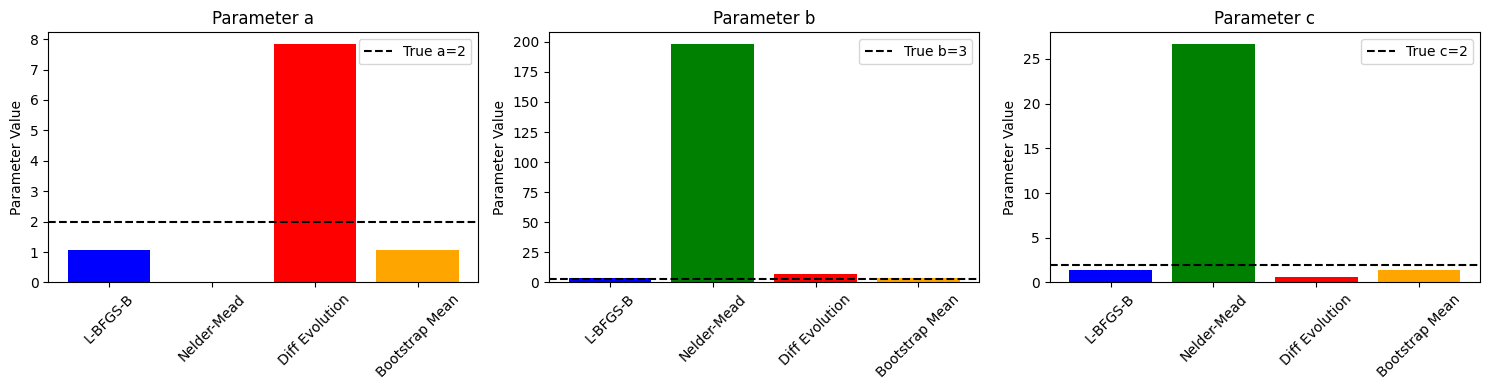


=== Method Comparison ===
Method               a          b          c          NLL         
-----------------------------------------------------------------
True Values          2.0000     3.0000     2.0000     —           
L-BFGS-B             1.0591     3.2955     1.3660     nan         
Nelder-Mead          0.0000     198.0191   26.6469    nan         
Diff Evolution       7.8332     7.3403     0.5780     nan         


In [51]:
# Comparison of Methods
import matplotlib.pyplot as plt

methods = ['L-BFGS-B', 'Nelder-Mead', 'Diff Evolution', 'Bootstrap Mean']
a_vals = [result.x[0], result_nm.x[0], result_de.x[0], ci_mean[0]]
b_vals = [result.x[1], result_nm.x[1], result_de.x[1], ci_mean[1]]
c_vals = [result.x[2], result_nm.x[2], result_de.x[2], ci_mean[2]]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].bar(methods, a_vals, color=['blue', 'green', 'red', 'orange'])
axes[0].axhline(a, color='black', linestyle='--', label=f'True a={a}')
axes[0].set_ylabel('Parameter Value')
axes[0].set_title('Parameter a')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(methods, b_vals, color=['blue', 'green', 'red', 'orange'])
axes[1].axhline(b, color='black', linestyle='--', label=f'True b={b}')
axes[1].set_ylabel('Parameter Value')
axes[1].set_title('Parameter b')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

axes[2].bar(methods, c_vals, color=['blue', 'green', 'red', 'orange'])
axes[2].axhline(c, color='black', linestyle='--', label=f'True c={c}')
axes[2].set_ylabel('Parameter Value')
axes[2].set_title('Parameter c')
axes[2].legend()
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary table
print("\n=== Method Comparison ===")
print(f"{'Method':<20} {'a':<10} {'b':<10} {'c':<10} {'NLL':<12}")
print("-" * 65)
print(f"{'True Values':<20} {a:<10.4f} {b:<10.4f} {c:<10.4f} {'—':<12}")
print(f"{'L-BFGS-B':<20} {result.x[0]:<10.4f} {result.x[1]:<10.4f} {result.x[2]:<10.4f} {result.fun:<12.4f}")
print(f"{'Nelder-Mead':<20} {result_nm.x[0]:<10.4f} {result_nm.x[1]:<10.4f} {result_nm.x[2]:<10.4f} {result_nm.fun:<12.4f}")
print(f"{'Diff Evolution':<20} {result_de.x[0]:<10.4f} {result_de.x[1]:<10.4f} {result_de.x[2]:<10.4f} {result_de.fun:<12.4f}")